In [2]:
# Import libraries
import csv
import re
import pylab
import time
import collections
import numpy as np
import nltk
import tensorflow as tf
from nltk.tokenize import word_tokenize
from tensorflow.keras import Model, layers
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

import pickle

nltk.download('punkt')

from google.colab import drive
drive.mount('/content/gdrive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Mounted at /content/gdrive


In [3]:
# RTX On
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Variables

In [4]:
# Initialize variables to be used later
MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
FILTER_SHAPE1 = [20, 256]
FILTER_SHAPE2= [20, 1]
FILTER_SHAPE3 = [20, 20]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15
 
batch_size = 128
one_hot_size = 256
no_epochs = 250
lr = 0.01
 
seed = 10
tf.random.set_seed(seed)

In [5]:
# Initialise variables for RNN
HIDDEN_SIZE = 20

# Char Functions

In [6]:
#Define functions to be used later
#Get all the unique characters used in the string supplied
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings)))))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    vocab_size = len(chars)
    return vocab_size, char_to_ix

#Preprocess strings and truncate if length longer than 100
def preprocess(strings, char_to_ix, MAX_LENGTH):
    data_chars = [list(d.lower()) for _, d in enumerate(strings)]
    for i, d in enumerate(data_chars):
        if len(d)>MAX_LENGTH:
            d = d[:MAX_LENGTH]
        elif len(d) < MAX_LENGTH:
            d += [' '] * (MAX_LENGTH - len(d))
            
    data_ids = np.zeros([len(data_chars), MAX_LENGTH], dtype=np.int64)
    for i in range(len(data_chars)):
        for j in range(MAX_LENGTH):
            data_ids[i, j] = char_to_ix[data_chars[i][j]]
    return np.array(data_ids)

#Read in the data in the train and test csv files
def read_data_chars():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('/content/gdrive/My Drive/Colab Notebooks/train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('/content/gdrive/My Drive/Colab Notebooks/test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))


    vocab_size, char_to_ix = vocabulary(x_train+x_test)
    x_train = preprocess(x_train, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    return x_train, y_train, x_test, y_test


x_train, y_train, x_test, y_test = read_data_chars()

#Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# RNN Training & Testing Functions

In [7]:
def train_step_2(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object_2(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step_2(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object_2(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

# Model Definition

In [8]:
# Build model
tf.keras.backend.set_floatx('float32')
class CharRNN(Model):

    def __init__(self, vocab_size=256, hidden_dim=10):
        super(CharRNN, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        
        # Weight variables and RNN cell
        self.rnn = layers.RNN(tf.keras.layers.GRUCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)

    def call(self, x, drop_rate):
        # forward logic
        categorical_labels = to_categorical(x, self.vocab_size)
        encoding = self.rnn(categorical_labels)
        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

In [9]:
#Choose optimizer and loss function for training
loss_object_2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

#Select metrics to measure the loss and the accuracy of the model. 
#These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Build the model
CharRNN_model = CharRNN(256, HIDDEN_SIZE)

# Train Model

In [ ]:
test_acc_CharRNN = []
train_acc_CharRNN = []
test_loss_CharRNN = []
train_loss_CharRNN = []
charRNN_timer = 0

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    epoch_start_time = time.perf_counter()
    
    for images, labels in train_ds:
        train_step_2(CharRNN_model, images, labels, drop_rate=0)

    for images, labels in test_ds:
        test_step_2(CharRNN_model, images, labels, drop_rate=0)

    epoch_end_time = time.perf_counter()
    charRNN_timer = charRNN_timer + epoch_end_time - epoch_start_time
    
    test_acc_CharRNN.append(test_accuracy.result())
    train_acc_CharRNN.append(train_accuracy.result())
    test_loss_CharRNN.append(test_loss.result())
    train_loss_CharRNN.append(train_loss.result())

    if ( (epoch+1)%50 == 0 ): 
        print('[Epoch {}]'.format(epoch+1))
        print('⏵Train Loss: {}'.format(train_loss.result()))
        print('⏵Train Acc:  {}'.format(train_accuracy.result()))
        print('⏵Test Loss:  {}'.format(test_loss.result()))
        print('⏵Test Acc:   {}'.format(test_accuracy.result()))
        print('')

print('Time Taken: {} seconds.'.format(charRNN_timer))

In [ ]:
instanced_variables = [test_acc_CharRNN, train_acc_CharRNN, test_loss_CharRNN, train_loss_CharRNN, charRNN_timer]

# create directory in your gdrive
filename = f'/content/gdrive/My Drive/Colab Output/Part_B_Q3_CharRNN_variables'
outfile = open(filename,'wb')
pickle.dump(instanced_variables, outfile)
outfile.close()

In [10]:
# Retrieve previously saved instanced variables w/ pickle rick
infile = open(f'/content/gdrive/My Drive/Colab Output/Part_B_Q3_CharRNN_variables', 'rb')
retrieved_variables = pickle.load(infile)
infile.close()

# Load retrieved variables into instance variables for plotting
test_acc_CharRNN, train_acc_CharRNN, test_loss_CharRNN, train_loss_CharRNN, charRNN_timer = retrieved_variables

In [11]:
# get highest accuracy values
highest_acc = max(test_acc_CharRNN)

# get average accuracy
average_acc = sum(test_acc_CharRNN)/len(test_acc_CharRNN)

print('Highest Acc')
print(highest_acc)

print('')

print('Avg Acc')
print(average_acc)

Highest Acc
tf.Tensor(0.71428573, shape=(), dtype=float32)

Avg Acc
tf.Tensor(0.67693716, shape=(), dtype=float32)


# Plot

## Accuracy Plot

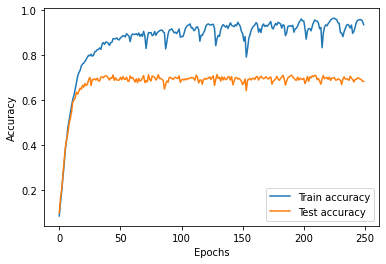

In [ ]:
# Plot test accuracy
plt.plot(train_acc_CharRNN,label="Train accuracy")
plt.plot(test_acc_CharRNN,label="Test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()
plt.close()

## Loss Plot

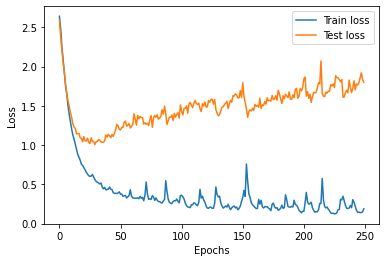

In [ ]:
# Plot train accuracy
plt.plot(train_loss_CharRNN,label="Train loss")
plt.plot(test_loss_CharRNN,label="Test loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()
plt.close()